In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
df = pd.read_csv('Terry_Stops.csv')

In [3]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47213 entries, 0 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47213 non-null  object
 1   Subject ID                47213 non-null  int64 
 2   GO / SC Num               47213 non-null  int64 
 3   Terry Stop ID             47213 non-null  int64 
 4   Stop Resolution           47213 non-null  object
 5   Weapon Type               47213 non-null  object
 6   Officer ID                47213 non-null  object
 7   Officer YOB               47213 non-null  int64 
 8   Officer Gender            47213 non-null  object
 9   Officer Race              47213 non-null  object
 10  Subject Perceived Race    47213 non-null  object
 11  Subject Perceived Gender  47213 non-null  object
 12  Reported Date             47213 non-null  object
 13  Reported Time             47213 non-null  object
 14  Initial Call Type     

In [5]:
df['Target'] = df['Stop Resolution']

In [6]:
df['Target'].unique()

array(['Arrest', 'Field Contact', 'Citation / Infraction',
       'Offense Report', 'Referred for Prosecution'], dtype=object)

In [7]:
df['Target'] = df['Target'].replace(['Arrest', 'Field Contact',
                                     'Citation / Infraction','Offense Report',
                                     'Referred for Prosecution' ], [1, 0, 0, 0 ,0])

In [8]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Target
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,1
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,-,-,-,NaN,N,N,-,-,-,0
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,-,-,-,NaN,N,-,-,-,-,0
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,-,-,-,NaN,N,N,-,-,-,0
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,-,-,-,NaN,N,N,-,-,-,0


In [9]:
df['Subject Perceived Race'].value_counts()

White                                        23052
Black or African American                    14046
Unknown                                       2626
-                                             1893
Hispanic                                      1684
Asian                                         1536
American Indian or Alaska Native              1359
Multi-Racial                                   809
Other                                          152
Native Hawaiian or Other Pacific Islander       56
Name: Subject Perceived Race, dtype: int64

In [10]:
unknown = df['Subject Perceived Race'].value_counts()[2]
blank = df['Subject Perceived Race'].value_counts()[3]

(unknown + blank)/df['Subject Perceived Race'].value_counts().sum()

0.09571516319657722

In [11]:
df['Reported Date'].sort_values()

1656     2015-03-15T00:00:00
28732    2015-03-16T00:00:00
3199     2015-03-16T00:00:00
3226     2015-03-16T00:00:00
13737    2015-03-17T00:00:00
                ...         
43292    2021-04-21T00:00:00
38379    2021-04-21T00:00:00
12992    2021-04-21T00:00:00
25114    2021-04-22T00:00:00
24753    2021-04-22T00:00:00
Name: Reported Date, Length: 47213, dtype: object

In [12]:
df['Reported Date'] = df['Reported Date'].astype('datetime64')

In [13]:
df['Reported Date']

0       2015-10-16
1       2015-03-19
2       2015-03-21
3       2015-04-01
4       2015-04-03
           ...    
47208   2021-04-19
47209   2021-03-11
47210   2021-03-15
47211   2021-04-13
47212   2021-04-13
Name: Reported Date, Length: 47213, dtype: datetime64[ns]

In [14]:
df['Reported Time'] = df['Reported Time'].astype('datetime64')

In [15]:
df['Weapon Type'].value_counts()

None                                    32565
-                                       11855
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         633
Handgun                                   291
Firearm Other                             100
Blunt Object/Striking Implement            86
Club, Blackjack, Brass Knuckles            49
Firearm                                    38
Mace/Pepper Spray                          28
Other Firearm                              23
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        9
None/Not Applicable                         7
Rifle                                       7
Fire/Incendiary Device                      6
Shotgun                                     3
Automatic Handgun                           2
Personal Weapons (hands, feet, etc.)        2
Blackjack                                   1
Brass Knuckles                    

In [16]:
df['Reported Time'] = df['Reported Time'].dt.time

In [17]:
df['Reported Time'][:5]

0    11:32:00
1    07:59:00
2    19:12:00
3    04:55:00
4    00:41:00
Name: Reported Time, dtype: object

In [18]:
df['Subject Age Group'].value_counts()

26 - 35         15707
36 - 45         10017
18 - 25          9452
46 - 55          6111
56 and Above     2399
1 - 17           1978
-                1549
Name: Subject Age Group, dtype: int64

In [19]:
df['Stop Resolution'].value_counts()

Field Contact               18993
Offense Report              15646
Arrest                      11667
Referred for Prosecution      728
Citation / Infraction         179
Name: Stop Resolution, dtype: int64

In [21]:
df.groupby('Subject Perceived Race')['Stop Resolution']\
           .value_counts(normalize=True)

Subject Perceived Race                     Stop Resolution         
-                                          Field Contact               0.666667
                                           Offense Report              0.219229
                                           Arrest                      0.104068
                                           Citation / Infraction       0.006867
                                           Referred for Prosecution    0.003170
American Indian or Alaska Native           Field Contact               0.362031
                                           Offense Report              0.322296
                                           Arrest                      0.291391
                                           Referred for Prosecution    0.019868
                                           Citation / Infraction       0.004415
Asian                                      Field Contact               0.396484
                                           Offense R

In [22]:
df[df['Stop Resolution'] == 'Arrest']['Subject Perceived Race'].value_counts(normalize=True)

White                                        0.472444
Black or African American                    0.335305
Unknown                                      0.050913
Asian                                        0.037285
Hispanic                                     0.034628
American Indian or Alaska Native             0.033942
-                                            0.016885
Multi-Racial                                 0.013885
Other                                        0.003428
Native Hawaiian or Other Pacific Islander    0.001286
Name: Subject Perceived Race, dtype: float64

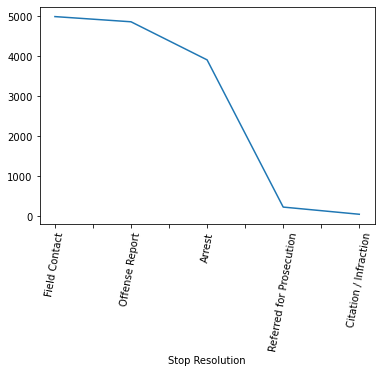

In [20]:
BAF_Stops = df.groupby('Subject Perceived Race')['Stop Resolution']\
           .value_counts()['Black or African American']

BAF_Stops.plot()
plt.xticks(rotation=80)
plt.show()

In [39]:
df.groupby('Subject Age Group')['Stop Resolution'].value_counts(normalize=True)

Subject Age Group  Stop Resolution         
1 - 17             Offense Report              0.465622
                   Field Contact               0.285137
                   Arrest                      0.219414
                   Referred for Prosecution    0.027806
                   Citation / Infraction       0.002022
18 - 25            Field Contact               0.375899
                   Offense Report              0.353999
                   Arrest                      0.246297
                   Referred for Prosecution    0.019149
                   Citation / Infraction       0.004655
26 - 35            Field Contact               0.390399
                   Offense Report              0.325205
                   Arrest                      0.267460
                   Referred for Prosecution    0.014388
                   Citation / Infraction       0.002547
36 - 45            Field Contact               0.416991
                   Offense Report              0.308376
    

In [24]:
df['Officer YOB']

0        1984
1        1965
2        1961
3        1963
4        1977
         ... 
47208    1996
47209    1981
47210    1992
47211    1989
47212    1985
Name: Officer YOB, Length: 47213, dtype: int64

In [25]:
df['Officer Squad'].fillna('NA', inplace=True)

In [26]:
df.replace('-', 'NA', inplace=True)

In [27]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Target
0,NA,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,NA,NA,NA,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,1
1,NA,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,NA,NA,NA,NA,N,N,NA,NA,NA,0
2,NA,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,NA,NA,NA,NA,N,NA,NA,NA,NA,0
3,NA,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,NA,NA,NA,NA,N,N,NA,NA,NA,0
4,NA,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,NA,NA,NA,NA,N,N,NA,NA,NA,0


In [28]:
df.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
Target                      0
dtype: int64

In [29]:
target_race = df.groupby('Subject Perceived Race')['Target'].value_counts(normalize=True)

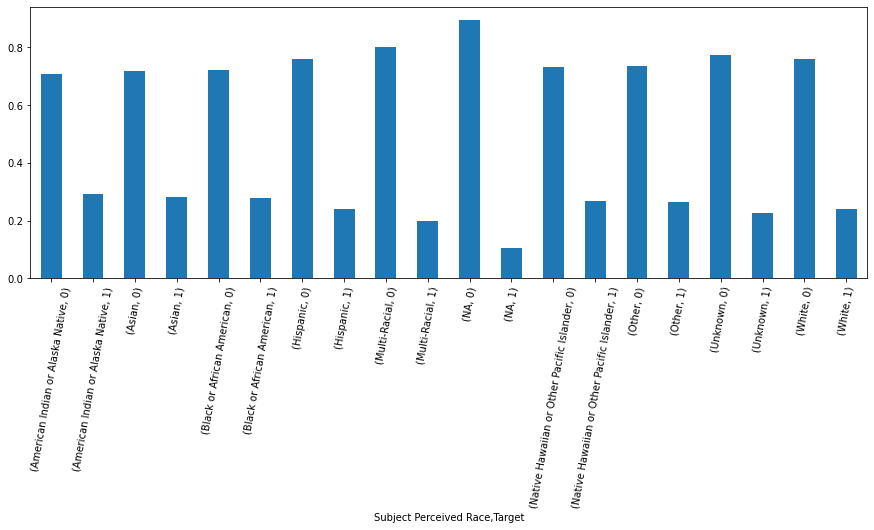

In [30]:
target_race.plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=80)
plt.show()

In [31]:
target_gender = df.groupby('Subject Perceived Gender')['Target'].value_counts()

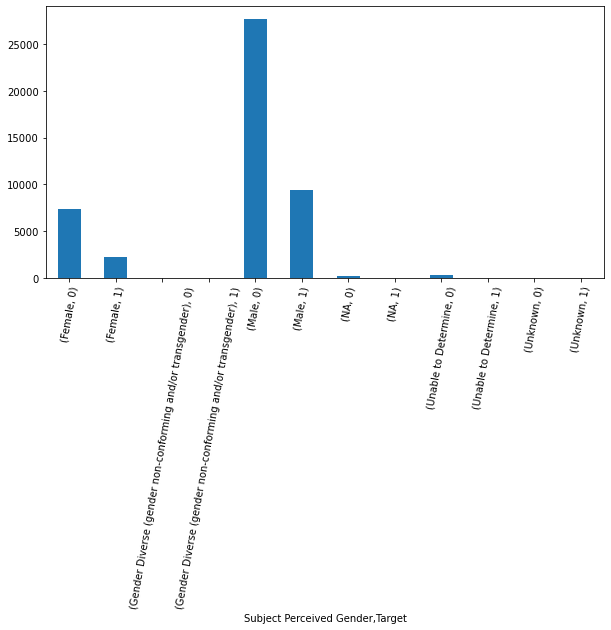

In [32]:
target_gender.plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=80)
plt.show()

In [33]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat', 'Target'],
      dtype='object')

In [36]:
df.drop(['Subject ID',  'GO / SC Num', 'Officer ID'], axis=1, inplace=True)

In [38]:
df.head()

,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Target
0,NA,92317,Arrest,None,1984,M,Black or African American,Asian,Male,2015-10-16,...,NA,NA,NA,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,1
1,NA,28806,Field Contact,None,1965,M,White,NA,NA,2015-03-19,...,NA,NA,NA,NA,N,N,NA,NA,NA,0
2,NA,29599,Field Contact,None,1961,M,White,White,Male,2015-03-21,...,NA,NA,NA,NA,N,NA,NA,NA,NA,0
3,NA,32260,Field Contact,None,1963,M,White,NA,NA,2015-04-01,...,NA,NA,NA,NA,N,N,NA,NA,NA,0
4,NA,33155,Field Contact,None,1977,M,White,Black or African American,Male,2015-04-03,...,NA,NA,NA,NA,N,N,NA,NA,NA,0


In [40]:
column_name = 'Target'
first_column = df.pop(column_name)
df.insert(0, column_name, first_column)

In [42]:
df.head()

,Target,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,1,NA,92317,Arrest,None,1984,M,Black or African American,Asian,Male,...,11:32:00,NA,NA,NA,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,0,NA,28806,Field Contact,None,1965,M,White,NA,NA,...,07:59:00,NA,NA,NA,NA,N,N,NA,NA,NA
2,0,NA,29599,Field Contact,None,1961,M,White,White,Male,...,19:12:00,NA,NA,NA,NA,N,NA,NA,NA,NA
3,0,NA,32260,Field Contact,None,1963,M,White,NA,NA,...,04:55:00,NA,NA,NA,NA,N,N,NA,NA,NA
4,0,NA,33155,Field Contact,None,1977,M,White,Black or African American,Male,...,00:41:00,NA,NA,NA,NA,N,N,NA,NA,NA
